In [53]:
# Predict whether a person makes over 50K per year or not from classic adult dataset using XGBoost.
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5) 
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1, header = None)
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation','relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

In [54]:
train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [55]:
test_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [56]:
# Replacing the '?' mark symbol with NaN values first and then dropping them
train_set = train_set.replace(' ?', np.nan).dropna()
train_set.shape 

(30162, 15)

In [57]:
# Replacing the '?' mark symbol with NaN values first and then dropping them
test_set = test_set.replace(' ?', np.nan).dropna() 
test_set.shape 

(15060, 15)

In [58]:
test_set['wage_class'] = test_set.wage_class.replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})

In [59]:
train_set['wage_class'] = train_set.wage_class.replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})

In [60]:
# Appending into a single dataset to handle the columns with categorical strings
dataset = pd.concat([train_set, test_set], axis = 0)

In [61]:
dataset.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [62]:
# Loop through all columns in the dataframe and replace strings (Categorical) with integers
for feature in dataset.columns: 
    if dataset[feature].dtype == 'object': 
        dataset[feature] = pd.Categorical(dataset[feature]).codes

In [63]:
dataset.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4,0


In [64]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
age               45222 non-null int64
workclass         45222 non-null int8
fnlwgt            45222 non-null int64
education         45222 non-null int8
education_num     45222 non-null int64
marital_status    45222 non-null int8
occupation        45222 non-null int8
relationship      45222 non-null int8
race              45222 non-null int8
sex               45222 non-null int8
capital_gain      45222 non-null int64
capital_loss      45222 non-null int64
hours_per_week    45222 non-null int64
native_country    45222 non-null int8
wage_class        45222 non-null int8
dtypes: int64(6), int8(9)
memory usage: 2.8 MB


In [65]:
# Setting the train datset after fixing the columns
train_dataset = dataset[:train_set.shape[0]]

In [66]:
# Setting the train datset after fixing the columns
test_dataset = dataset[:test_set.shape[0]]

In [67]:
# Setting our target variable
y_train = train_dataset.pop('wage_class')
y_test = test_dataset.pop('wage_class')

In [68]:
# Tuning on the maximum depth of the trees along with the min_child_weight. 
# Setting the objective to 'binary:logistic' since this is a binary classification problem. 
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1)

In [69]:
# Fitting our model
optimized_GBM.fit(train_dataset, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [50]:
# Checking our grid scores
optimized_GBM.grid_scores_

[mean: 0.86685, std: 0.00239, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.86659, std: 0.00371, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.86725, std: 0.00317, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.86178, std: 0.00317, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.85953, std: 0.00251, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.86158, std: 0.00239, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.85611, std: 0.00330, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.85525, std: 0.00323, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.85714, std: 0.00320, params: {'max_depth': 7, 'min_child_weight': 5}]

In [70]:
# To increase the performance of XGBoost's speed through many iterations,we can create a DMatrix. 
# This sorts the data initially to optimize for XGBoost when it builds trees.
xgdmat = xgb.DMatrix(train_dataset, y_train) 

In [71]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1}

In [72]:
# Grid Search CV optimized settings using dmatrix and early stopping
cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,metrics = ['error'],early_stopping_rounds = 100)

In [80]:
cv_xgb.tail(5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
457,0.116570,0.001104,0.130173,0.004067
458,0.116578,0.001137,0.130106,0.004026
459,0.116520,0.001080,0.130040,0.003949
460,0.116537,0.001141,0.130073,0.003919
461,0.116512,0.001133,0.129974,0.003961


In [83]:
# Training our model with optimized settings
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 461)

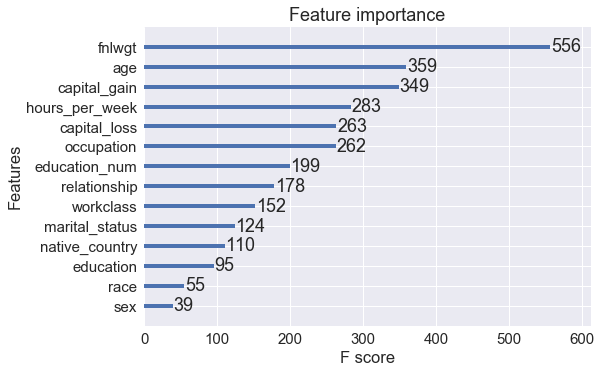

In [84]:
# Plotting the importance of featues which contributes more in deciding the person's income
xgb.plot_importance(final_gb)

In [85]:
# Analyzing our test data
testdmat = xgb.DMatrix(test_dataset)

In [86]:
# Predict using our testdmat
y_pred = final_gb.predict(testdmat)
y_pred

array([0.00742831, 0.2631242 , 0.03453045, ..., 0.83888614, 0.0081835 ,
       0.46842608], dtype=float32)

In [87]:
# To calculate accuracy we need to convert these to a 0/1 label. We will set 0.5 probability as our threshold.
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([0., 0., 0., ..., 1., 0., 0.], dtype=float32)

In [89]:
accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(0.8803452855245684, 0.11965471447543163)

In [90]:
print("The accuracy of our model is almost 88%")

The accuracy of our model is almost 88%
